In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

# Shi-Tomasi's good features to track
an extension of the Harris corner detector <br/>
taken from [opencv doc](https://docs.opencv.org/4.x/d4/d8c/tutorial_py_shi_tomasi.html)

In [2]:
img = cv.imread('images/IMG_0059.jpeg')
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

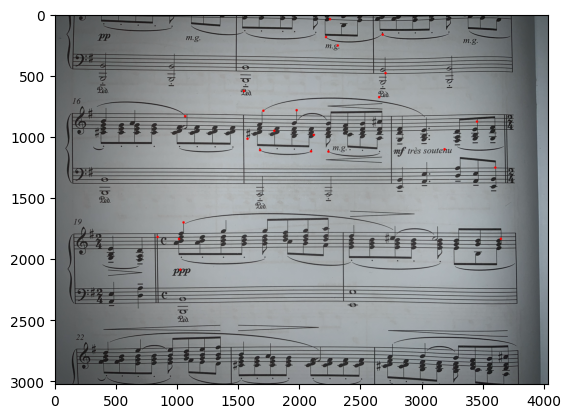

(<matplotlib.image.AxesImage at 0x7f75521ca150>, None)

In [3]:
corners = cv.goodFeaturesToTrack(gray,25,0.01,100)
corners = np.int_(corners)
 
for i in corners:
    x,y = i.ravel()
    cv.circle(img,(x,y),10,255,-1)
 
plt.imshow(img),plt.show()